# **Import library yang dibutuhkan**

In [25]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

In [26]:
# readme file
txt_files = '/content/README.txt'
with open(txt_files, 'r') as file:
    content = file.read()
    print(content)

Summary

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. More details about the contents and use of all these files follows.

This is a *development* dataset. As such, it may change over time and is not an appropriate dataset for shared research results. See available *benchmark* datasets if that is your intent.

This and other GroupLens data sets are publicly available for down

Berdasarkan informasi yang diperoleh dari readme file, saya akan menggunakan dataset movies.csv dan ratings.csv untuk keperluan pembuatan sistem rekomendasi.

# **Data Understanding**

Dataset yang digunakan berasal dari [Movielens Latest Datasets](https://grouplens.org/datasets/movielens/latest/). Dataset yang saya ambil adalah kategori small yang berisikan 100.000 rating dan 3.600 aplikasi tag yang diterapkan pada 9.000 film oleh 600 pengguna. Adapun terakhir kali diperbarui pada 9/2018. Dataset ini sering digunakan untuk pengembangan dan evaluasi sitem rekomendasi.

## Data Loading

Pada saat load dataset saya hanya memilih dataset movies dan ratings untuk keperluan pembuatan sistem rekomendasi

In [27]:
# Load dataset yang digunakan

movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')

print(f'Jumlah data film dalam dataset movies: {movies.movieId.nunique()}')
print(f'Jumlah data ratings atau penilaian dalam dataset ratings: {ratings.movieId.nunique()}')

Jumlah data film dalam dataset movies: 9742
Jumlah data ratings atau penilaian dalam dataset ratings: 9724


In [28]:
# cek tipe data dataset movies
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Dataset movies memiliki struktur sebagai berikut:
1. `movieId`: Id unik untuk setiap film
2. `tittle`: judul film disertai tahun rilis fim
3. `genres`: genre film yang dipisahkan dengan karkater '|', contohnya Comedy|Romance

Struktur dataset movies memiliki informasi lengkap tentang jumlah kolom dan baris, tipe data, serta jumlah nilai non-null di setiap kolom.

In [29]:
# cek tipe data dataset ratings
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Dataset ratings memiliki struktur sebagai berikut:
1. `userId`: ID unik untuk setiap pengguna
2. `movieID`: ID film yang diberi rating oleh pengguna
3. `rating`: peringkat atau nilai rating yang diberikan oleh pengguna (skala 0.5 - 5.0 dengan interval 0.5)
4. `timestamp`: waktu ketika penilaian (rating) diberikan

Struktur dataset ratings memiliki informasi yang lengkap tentang jumlah kolom dan baris, tipe data, serta jumlah nilai non-null di setiap kolom.

## Data preparation

In [30]:
# cek dataset film
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [31]:
# Menyimpan tahun rilis di kolom baru 'year_of_release'
movies['year_of_release'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False)

# Menghapus tahun dari judul film
movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True)

# Menghapus spasi tambahan setelah penghapusan tahun
movies['title'] = movies['title'].str.strip()

# Menampilkan hasil
movies.head()

,movieId,title,genres,year_of_release
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [32]:
# Mengubah year_of_release menjadi numerik
movies['year_of_release'] = pd.to_numeric(movies['year_of_release'], errors='coerce')

# Menampilkan tipe data baru
print(movies.dtypes)

movieId              int64
title               object
genres              object
year_of_release    float64
dtype: object


In [33]:
# cek dataset rating
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [34]:
# cek nilai unik dalam kolom rating
ratings['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [35]:
from collections import Counter

# Mengelompokkan rating berdasarkan movieId dan menghitung rata-rata serta jumlah rating
movie_ratings = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()

# Menghitung jumlah genre untuk setiap film di dataset movies
movies['genre_count'] = movies['genres'].apply(lambda x: len(x.split('|')))

# Membuat daftar dari semua genre yang ada dalam dataset movies untuk analisis distribusi genre
all_genres = []
for genres in movies['genres']:
    # Memisahkan string genre dan menambahkannya ke daftar all_genres
    all_genres.extend(genres.split('|'))

# Menghitung frekuensi kemunculan setiap genre
genres_count = Counter(all_genres)

print(f"Ditemukan {len(genres_count)} genre unik")

Ditemukan 20 genre unik


In [36]:
# Menampilkan genre dan jumlahnya
print("Genre dan jumlah kemunculannya:")
for genre, count in genres_count.items():
    print(f"{genre}: {count}")

Genre dan jumlah kemunculannya:
Adventure: 1263
Animation: 611
Children: 664
Comedy: 3756
Fantasy: 779
Romance: 1596
Drama: 4361
Action: 1828
Crime: 1199
Thriller: 1894
Horror: 978
Mystery: 573
Sci-Fi: 980
War: 382
Musical: 334
Documentary: 440
IMAX: 158
Western: 167
Film-Noir: 87
(no genres listed): 34


Ditemukan kategori no genre listed sebanyak 34 film, nantinya kategori ini akan dihapus karena jumlahnya yang sedikit daripada total film 9000an. Hal ini dikarenakan no genre listed dianggap missing values sehingga dapat memengaruhi sistem rekomendasi.

In [37]:
# mengonversi timestamp menjadi date time
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51
5,1,70,3.0,2000-07-30 18:40:00
6,1,101,5.0,2000-07-30 18:14:28
7,1,110,4.0,2000-07-30 18:36:16
8,1,151,5.0,2000-07-30 19:07:21
9,1,157,5.0,2000-07-30 19:08:20


Untuk sementara, dataframe user ratings sudah terlihat cukup baik.

In [38]:
# menggabungkan dataframe movies dan ratings menjadi satu dataframe films utuh
films = pd.merge(ratings, movies, on='movieId', how='left')
films

,userId,movieId,rating,timestamp,title,genres,year_of_release,genre_count
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,5
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,Comedy|Romance,1995.0,2
2,1,6,4.0,2000-07-30 18:37:04,Heat,Action|Crime|Thriller,1995.0,3
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),Mystery|Thriller,1995.0,2
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The",Crime|Mystery|Thriller,1995.0,3
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,Split,Drama|Horror|Thriller,2017.0,3
100832,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,Action|Crime|Thriller,2017.0,3
100833,610,168250,5.0,2017-05-08 19:50:47,Get Out,Horror,2017.0,1
100834,610,168252,5.0,2017-05-03 21:19:12,Logan,Action|Sci-Fi,2017.0,2


Dataset digabung menggunakan metode `left join` dengan kolom `movieId` sebagai kunci penghubung. Pendekatan ini memastikan bahwa seluruh informasi rating tetap terjaga, sementara detail mengenai film ditambahkan ke setiap data rating yang relevan. Hasil dari penggabungan ini memungkinkan analisis preferensi pengguna terhadap film berdasarkan karakteristiknya dalam tahap Exploratory Data Analysis (EDA).


In [39]:
# mengecek missing values dalam dataset

print(f'Jumlah missing values dalam dataset films: {films.isnull().sum()}')

Jumlah missing values dalam dataset films: userId              0
movieId             0
rating              0
timestamp           0
title               0
genres              0
year_of_release    18
genre_count         0
dtype: int64


In [40]:
# menghapus missing values dalam dataset

films = films.dropna()
films

,userId,movieId,rating,timestamp,title,genres,year_of_release,genre_count
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,5
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,Comedy|Romance,1995.0,2
2,1,6,4.0,2000-07-30 18:37:04,Heat,Action|Crime|Thriller,1995.0,3
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),Mystery|Thriller,1995.0,2
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The",Crime|Mystery|Thriller,1995.0,3
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,Split,Drama|Horror|Thriller,2017.0,3
100832,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,Action|Crime|Thriller,2017.0,3
100833,610,168250,5.0,2017-05-08 19:50:47,Get Out,Horror,2017.0,1
100834,610,168252,5.0,2017-05-03 21:19:12,Logan,Action|Sci-Fi,2017.0,2


In [41]:
# cek kembali missing values dalam dataset

print(f'Jumlah missing values dalam dataset films: {films.isnull().sum()}')

Jumlah missing values dalam dataset films: userId             0
movieId            0
rating             0
timestamp          0
title              0
genres             0
year_of_release    0
genre_count        0
dtype: int64


Saat pengecekan jumlah genres unik dalam dataset, ditemukan kategori no genre listed pada kolom genre. Ini akan memengaruhi sistem rekomendasi pada contend-based diltering. Oleh karena itu mengingat jumlah datanya sedikit maka saya memilih menghapusnya.

In [42]:
# menghapus kategori no genres listed pada kolom genres untuk dataset gabungan films
films = films[films['genres'] != '(no genres listed)']
films

,userId,movieId,rating,timestamp,title,genres,year_of_release,genre_count
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,5
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,Comedy|Romance,1995.0,2
2,1,6,4.0,2000-07-30 18:37:04,Heat,Action|Crime|Thriller,1995.0,3
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),Mystery|Thriller,1995.0,2
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The",Crime|Mystery|Thriller,1995.0,3
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,Split,Drama|Horror|Thriller,2017.0,3
100832,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,Action|Crime|Thriller,2017.0,3
100833,610,168250,5.0,2017-05-08 19:50:47,Get Out,Horror,2017.0,1
100834,610,168252,5.0,2017-05-03 21:19:12,Logan,Action|Sci-Fi,2017.0,2


In [43]:
# mengecek duplikasi data dalam dataset films

print(f'Jumlah duplikasi data dalam dataset films: {films.duplicated().sum()}')

Jumlah duplikasi data dalam dataset films: 0


In [44]:
# menghapus kategori no genres listed pada kolom genres untuk dataset movies
movies = movies[movies['genres'] != '(no genres listed)']
movies

,movieId,title,genres,year_of_release,genre_count
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,5
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,3
2,3,Grumpier Old Men,Comedy|Romance,1995.0,2
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,3
4,5,Father of the Bride Part II,Comedy,1995.0,1
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017.0,4
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017.0,3
9739,193585,Flint,Drama,2017.0,1
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018.0,2


In [45]:
# mengecek duplikasi data dalam dataset movies

print(f'Jumlah duplikasi data dalam dataset movies: {movies.duplicated().sum()}')

Jumlah duplikasi data dalam dataset movies: 0


Saat menampilkan daftar genre film, saya memperhatikan adanya kategori **'Sci-Fi'**. **'Sci-Fi'** merupakan akronim dari **'Science Fiction'**, yang merujuk pada film bertema fiksi ilmiah. Namun, penggunaan tanda hubung (`-`) dalam akronim ini berpotensi menimbulkan masalah dalam tahap **vektorisasi TF-IDF**, karena sistem akan memisahkannya menjadi dua kata terpisah: **'Sci'** dan **'Fi'**, yang dapat mengganggu pemrosesan teks dan pemetaan genre secara akurat. Oleh karena itu, pemisah ini sebaiknya dihilangkan agar istilah tetap dikenali sebagai satu kesatuan dan tetap merepresentasikan genre fiksi ilmiah dengan benar dalam analisis data.


In [46]:
# mengubah Sci-Fi menjadi Scifi
films = films.replace(to_replace ='[nS]ci-Fi', value = 'Scifi', regex = True)
films.head()

,userId,movieId,rating,timestamp,title,genres,year_of_release,genre_count
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,5
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,Comedy|Romance,1995.0,2
2,1,6,4.0,2000-07-30 18:37:04,Heat,Action|Crime|Thriller,1995.0,3
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),Mystery|Thriller,1995.0,2
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The",Crime|Mystery|Thriller,1995.0,3


In [47]:
# mengubah Sci-Fi menjadi Scifi pada dataset movies
movies = movies.replace(to_replace ='[nS]ci-Fi', value = 'Scifi', regex = True)
movies.head()

,movieId,title,genres,year_of_release,genre_count
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,5
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,3
2,3,Grumpier Old Men,Comedy|Romance,1995.0,2
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,3
4,5,Father of the Bride Part II,Comedy,1995.0,1


## Ekstraksi Fitur dengan TF-IDF

In [51]:
# TF-IDF pada data genre film
tfidf = TfidfVectorizer(token_pattern=r'[^|]+') # karena genre dipisahkan dengan karakter "|"
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Melihat dimensi matriks TF-IDF
print(f"Dimensi matriks TF-IDF: {tfidf_matrix.shape}")

Dimensi matriks TF-IDF: (9708, 19)


Pada tahapan di atas, saya telah melakukan ekstraksi fitur utama yang diperlukan untuk membangun model rekomendasi berbasis konten:  

- **TF-IDF Vectorization**: Teknik ini digunakan untuk mengubah informasi genre ke dalam format numerik. TF-IDF membantu menentukan tingkat kepentingan setiap genre dalam suatu film dengan mempertimbangkan distribusinya di seluruh dataset.  

- **Konfigurasi Token Pattern**: Karena genre dalam dataset dipisahkan oleh karakter '|', pola token khusus (`token_pattern=r'[^|]+'`) diterapkan agar setiap genre dikenali sebagai satu token terpisah oleh TF-IDF.  

- **Matriks TF-IDF** yang telah terbentuk nantinya akan digunakan dalam pengembangan model **Content-Based Filtering**, memungkinkan sistem rekomendasi memberikan saran film yang lebih sesuai dengan preferensi pengguna.



# **Exploratory Data Analysis**

In [52]:
# Statistik deskriptif untuk dataset movies
print("Statistik Deskriptif untuk Dataset Movies:")
movies.describe()

Statistik Deskriptif untuk Dataset Movies:


,movieId,year_of_release,genre_count
count,9708.000000,9704.000000,9708.000000
mean,41798.469304,1994.589345,2.271323
std,51795.358095,18.531818,1.122704
min,1.000000,1902.000000,1.000000
25%,3233.750000,1987.750000,1.000000
50%,7256.500000,1999.000000,2.000000
75%,74809.000000,2008.000000,3.000000
max,193609.000000,2018.000000,10.000000


Berdasarkan hasil statistik deskriptif yang ditampilkan, terdapat beberapa informasi yang diperoleh mengenai kolom-kolom numerik dalam dataset movies yakni
- `movieId`: nilai ID berkisar antara 1 hingga 193609 dengan rata-rata 41798. Sebagian besar ID film berada dalam kisaran 3233 hingga 74809 (kuartil ke-1 hingga ke-3)
- `year_of_release`: tahun rilis berkisar antara tahun 1902 hingga 2018 dengan rata-rata di tahun 1994. Sebagian besar film berada dalam kisaran tahun 1987 hingga 2008 (kuartil ke-1 hingga ke-3)
- `genre_count`: jumlah genre yang dimiliki oleh tiap film berkisar antara 1 hingga 10 dengan rata-rata 2 genre. Sebagian besar film memiliki genre dalam kisaran 1 hingga 3 (kuartil ke-1 hingga ke-3)

In [53]:
# Statistik deskriptif untuk dataset rating
print("Statistik Deskriptif untuk Dataset Ratings:")
ratings.describe()

Statistik Deskriptif untuk Dataset Ratings:


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,100836
mean,326.127564,19435.295718,3.501557,2008-03-19 17:01:27.368469248
min,1.000000,1.000000,0.500000,1996-03-29 18:36:55
25%,177.000000,1199.000000,3.000000,2002-04-18 09:57:46
50%,325.000000,2991.000000,3.500000,2007-08-02 20:31:02
75%,477.000000,8122.000000,4.000000,2015-07-04 07:15:44.500000
max,610.000000,193609.000000,5.000000,2018-09-24 14:27:30
std,182.618491,35530.987199,1.042529,NaN


Berdasarkan hasil statistik deskriptif yang ditampilkan, terdapat beberapa informasi yang diperoleh mengenai kolom-kolom numerik dalam dataset ratings, yakni:
1. `userId`: ID pengguna berkisar antara 1 hingga 610 dengan rata-rata ID pengguna berada di angka 326. Sebagian besar memiliki ID dalam kisaran 177 hingga 477 (kuartil ke-1 hingga ke-3)
2. `movieId`: ID film yang diberi rating oleh pengguna berada dalam rentang 1 hingga 193609 dengan rata-rata 19435. Sebagian besar film yang diberi rating berada dalam ID 1199 hingga 8122. Ini menunjukkan bahwa film-film dengan ID lebih kecil cenderung lebih banyak diberi rating.
3. `rating`: rating yang diberikan pengguna berkisar antara 0,5 hingga 5 dengan rata-rata rating adalah 3,5. Sebagian besar rating berada pada rentang 3,0 hingga 4,0. Ini menunjukkan adanya kecenderungan pengguna memberikan rating cukup positif terhadap film yang mereka tonton.
4. `timestamp`: aktivitas rating yang dilakukan oleh pengguna berkisar antara pukul 18.36 tanggal 29/3/1996 hingga pukul 14.27 tanggal 24/9/2018 dengan rata-rata aktivitas rating yang dilakukan pengguna berkisar pada pukul 17.01 tanggal 19/3/2008. Kemudian sebagian besar aktivitas rating dilakukan antara pukul 09.57 tanggal 18/4/2002 hingga pukul 07.15 tanggal 4/7/2015. Ini menunjukkan bahwa aktivitas dominan terjadi dalam kurun waktu tahun 2002 hingga 2015.

In [54]:
# Statistik deksriptif untuk dataset gabungan
print("Statistik Deskriptif untuk Dataset Gabungan:")
films.describe()

Statistik Deskriptif untuk Dataset Gabungan:


,userId,movieId,rating,timestamp,year_of_release,genre_count
count,100781.000000,100781.000000,100781.000000,100781,100781.000000,100781.000000
mean,326.120281,19365.341652,3.501578,2008-03-17 18:34:46.426796800,1994.440281,2.722894
min,1.000000,1.000000,0.500000,1996-03-29 18:36:55,1902.000000,1.000000
25%,177.000000,1198.000000,3.000000,2002-04-07 12:46:17,1990.000000,2.000000
50%,325.000000,2990.000000,3.500000,2007-08-02 20:22:20,1997.000000,3.000000
75%,477.000000,8014.000000,4.000000,2015-07-04 07:04:20,2003.000000,3.000000
max,610.000000,193609.000000,5.000000,2018-09-24 14:27:30,2018.000000,10.000000
std,182.607564,35408.178857,1.042426,NaN,14.358870,1.192980


Berdasarkan hasil statistik deskriptif dataset gabungan yang ditampilkan, terdapat beberap informasi yang diperoleh mengenai kolom-kolom numerik yakni:
1. `movieId`: ID film yang diberi rating oleh pengguna berkisar antara 1 hingga 193609 dengan rata-rata 19365. Sebagian besar film yang diberi rating berada dalam rentang ID 1198 hingga 8014. Ini menandakan bahwa ID lebih kecil cenderung memiliki lebih banyak film yang diberi rating.
2. `year_of_release`: tahun rilis film berkisar antara tahun 1902 hingga 2018 dengan rata-rata di tahun 1994. Sebagian besar film dirilis berada dalam kisaran tahun 1990 hingga 2003. Ini menandakan bahwa banyak film yang diproduksi pada rentang tahun 1990 hingga 2003.
3. `genre_count`: jumlah genre yang dimiliki oleh tiap film berkisar antara 1 hingga 10 dengan rata-rata 2 genre. Sebagian besar film memiliki genre dalam kisaran 1 hingga 3 (kuartil ke-1 hingga ke-3). Ini menandakan bahwa banyak film yang memiliki banyak genre.
4. `userId`: ID pengguna berkisar antara 1 hingga 510 edngan rata-rata ID pengguna berada di angka 326. Sebagian besar pengguna memiliki ID dalam kisaran 177 hinga 477. Ini menunjukkan bahwa kecenderungan pengguna yang memberi rating adalah pada rentang ID pengguna 177 hingga 477.
5. `rating`: rating yang diberikan pengguna berkisar antara 0,5 hingga 5 dengan rata-rata rating adalah 3,5. Sebagian besar rating berada pada rentang 3,0 hingga 4,0. Ini menunjukkan adanya kecenderungan pengguna memberikan rating cukup positif terhadap film yang mereka tonton.
6. `timestamp`: aktivitas rating yang dilakukan oleh pengguna berkisar antara pukul 18.36 tanggal 29/3/1996 hingga pukul 14.27 tanggal 24/9/2018 dengan rata-rata aktivitas rating yang dilakukan pengguna berkisar pada pukul 18.34 tanggal 17/3/2008. Kemudian sebagian besar aktivitas rating dilakukan antara pukul 12.46 tanggal 7/4/2002 hingga pukul 07.04 tanggal 4/7/2015. Ini menunjukkan bahwa aktivitas dominan terjadi dalam kurun waktu tahun 2002 hingga 2015.

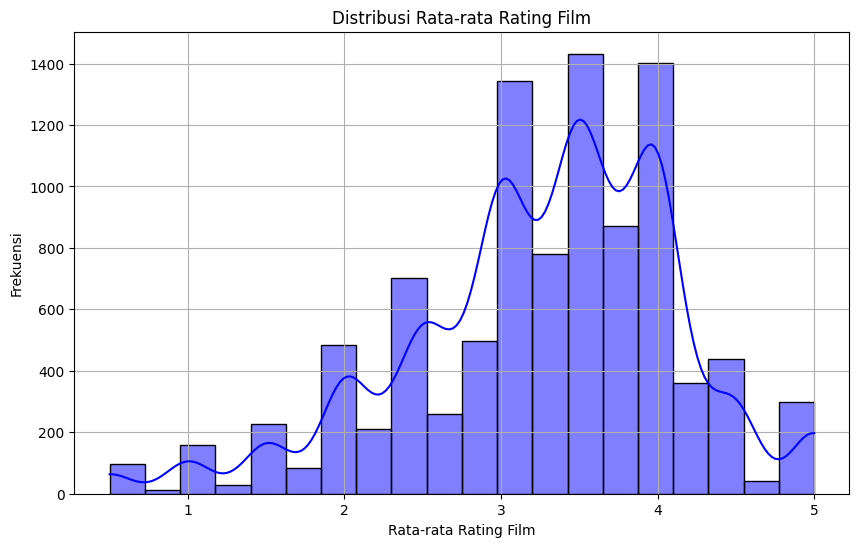

In [55]:
# Menghitung rata-rata rating per film
movie_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()

# Plot distribusi rating
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings['rating'], bins=20, kde=True, color='blue')

# Menambahkan label dan judul
plt.xlabel("Rata-rata Rating Film")
plt.ylabel("Frekuensi")
plt.title("Distribusi Rata-rata Rating Film")
plt.grid(True)

plt.show()

Grafik distribusi rata-rata rating film menunjukkan bahwa mayoritas pengguna cenderung memberikan rating 3.5 dengan frekuensi sekitar 1400 lebih pengguna. Informasi lainnya, sebagian besar rating berkisar antara 3.0 dan 4.0 menunjukkan kecenderungan pengguna untuk menilai film secara positif.  

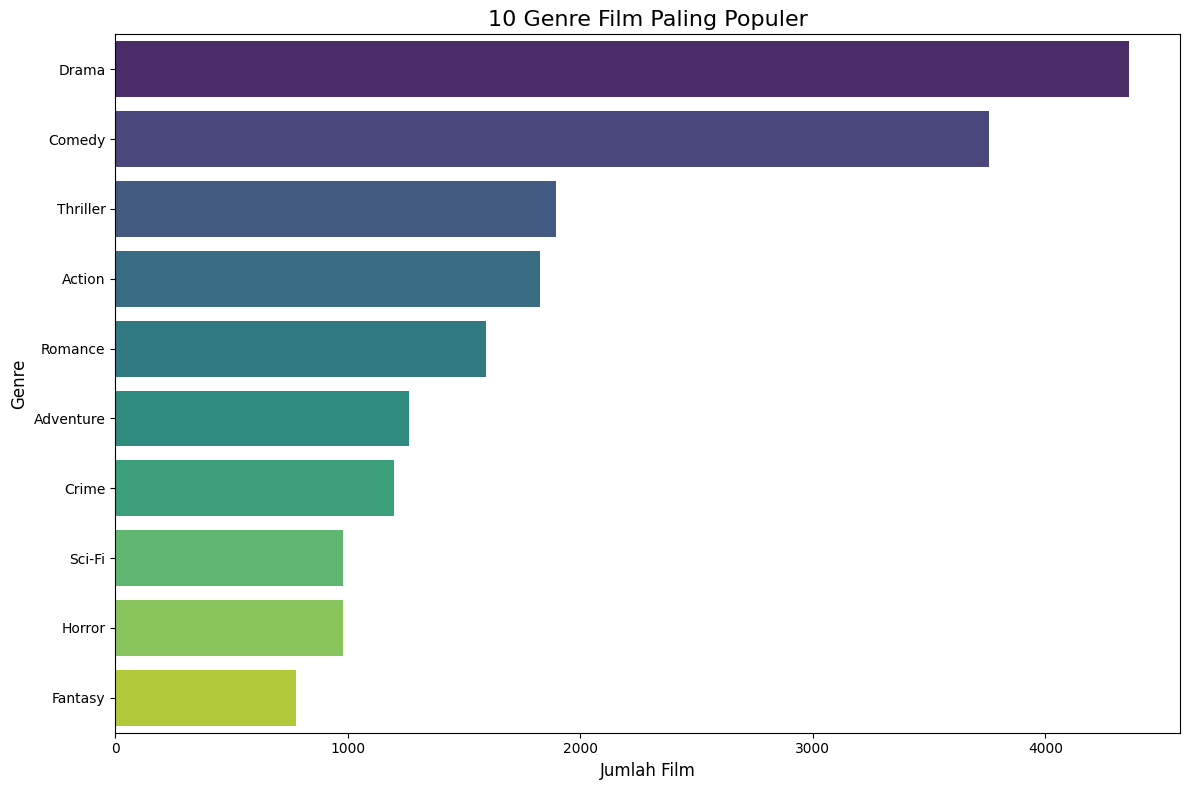

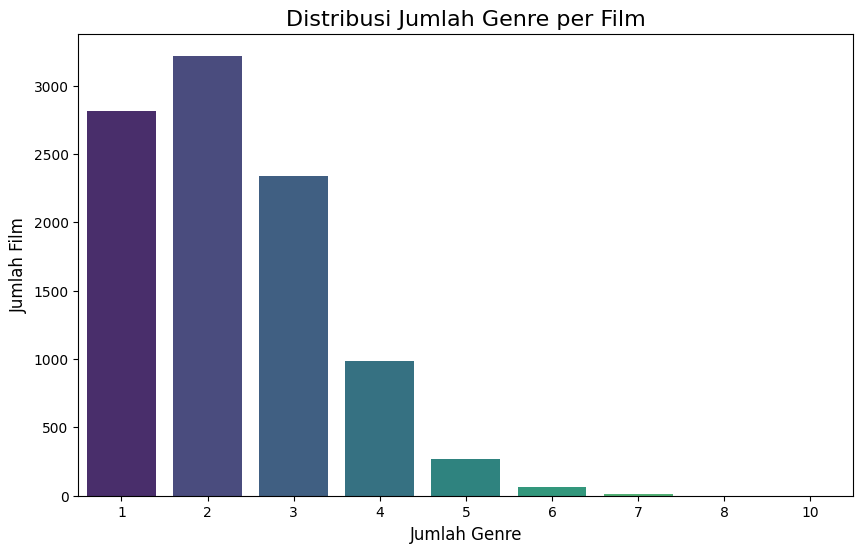

In [56]:
# Langkah 1: Menampilkan Distribusi Genre Film
plt.figure(figsize=(12, 8))

# Mengurutkan genre berdasarkan jumlah kemunculan dan mengubahnya ke dalam format dataframe
sorted_genres = sorted(genres_count.items(), key=lambda x: x[1], reverse=True)
genre_df = pd.DataFrame(sorted_genres, columns=['genre', 'count'])

# Memvisualisasikan 15 genre paling populer dalam dataset
sns.barplot(x='count', y='genre', data=genre_df.head(10), palette='viridis')
plt.title('10 Genre Film Paling Populer', fontsize=16)
plt.xlabel('Jumlah Film', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

# Langkah 2: Analisis Jumlah Genre dalam Film
plt.figure(figsize=(10, 6))

# Menghitung variasi jumlah genre per film berdasarkan dataset movies
movies_genre_distribution = movies[['movieId', 'genre_count']].copy()

# Memvisualisasikan sebaran jumlah genre dalam setiap film
sns.countplot(x='genre_count', data=movies_genre_distribution, palette='viridis')
plt.title('Distribusi Jumlah Genre per Film', fontsize=16)
plt.xlabel('Jumlah Genre', fontsize=12)
plt.ylabel('Jumlah Film', fontsize=12)
plt.show()

Berdasarkan visualisasi data distribusi genre film di atas memberikan infromasi bahwa genre film yang paling banyak diproduksi adalah Drama dan Comedy sebanyak masing-masing 4000an dan lebih dari 3500 film. Ini berarti kedua genre tersebut telah mendominasi dunia perfilman. Dilanjutkan genre Thriller, Action, dan Romance yang cukup populer menjadi top 3,4, dan 5 film teratas. Di sisi lain, sebagian besar film memiliki 1 hingga 3 genre dengan jumlah tertinggi terdapat pada film yang memiliki 2 genre, diikuti oleh 1 dan 3.

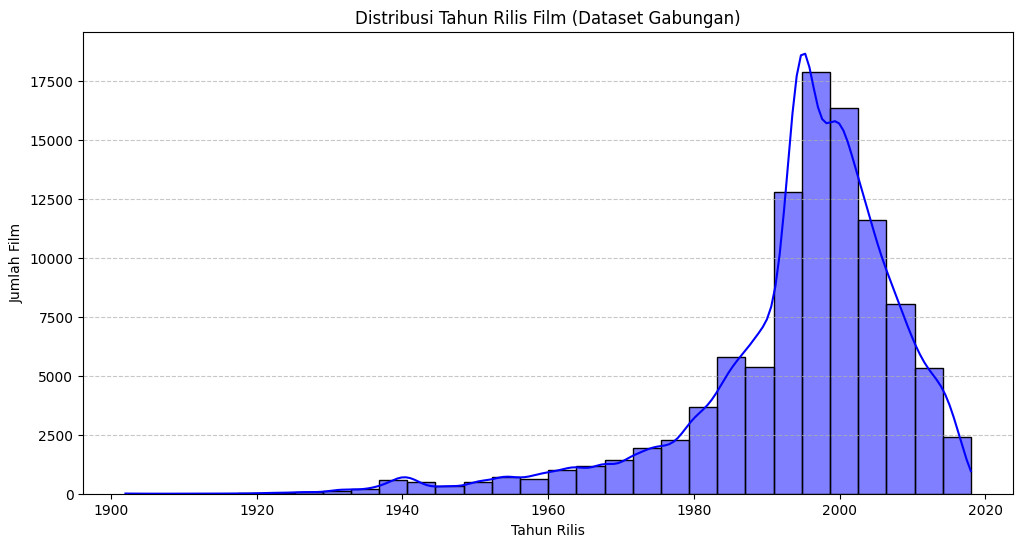

In [57]:
# Plot distribusi tahun rilis film
plt.figure(figsize=(12, 6))
sns.histplot(films['year_of_release'], bins=30, kde=True, color='blue')

# Menambahkan label dan judul
plt.xlabel("Tahun Rilis")
plt.ylabel("Jumlah Film")
plt.title("Distribusi Tahun Rilis Film (Dataset Gabungan)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Distribusi jumlah film yang dirilis setiap tahun menunjukkan pola pertumbuhan yang mencerminkan dinamika industri perfilman selama lebih dari satu abad. Pada periode sebelum tahun 1970, produksi film berlangsung dalam skala yang lebih terbatas, dengan jumlah rilis yang cenderung stabil di bawah 50 film per tahun. Namun, memasuki dekade 1970-an, terjadi percepatan signifikan dalam jumlah produksi, yang kemudian meningkat lebih tajam setelah tahun 1980. Tren ini mencapai puncaknya pada awal 2000-an, dengan jumlah film yang dirilis per tahun melampaui 300 judul, menandai era ekspansi industri secara masif. Setelah tahun 2015, terlihat adanya penurunan tajam dalam jumlah film yang tercatat, yang kemungkinan besar bukan akibat dari berkurangnya produksi, melainkan keterbatasan data terbaru yang belum sepenuhnya terakumulasi. Secara keseluruhan, grafik ini mengilustrasikan bagaimana industri film mengalami evolusi yang pesat, didorong oleh berbagai faktor seperti teknologi, permintaan pasar, dan perubahan lanskap distribusi film dalam beberapa dekade terakhir.


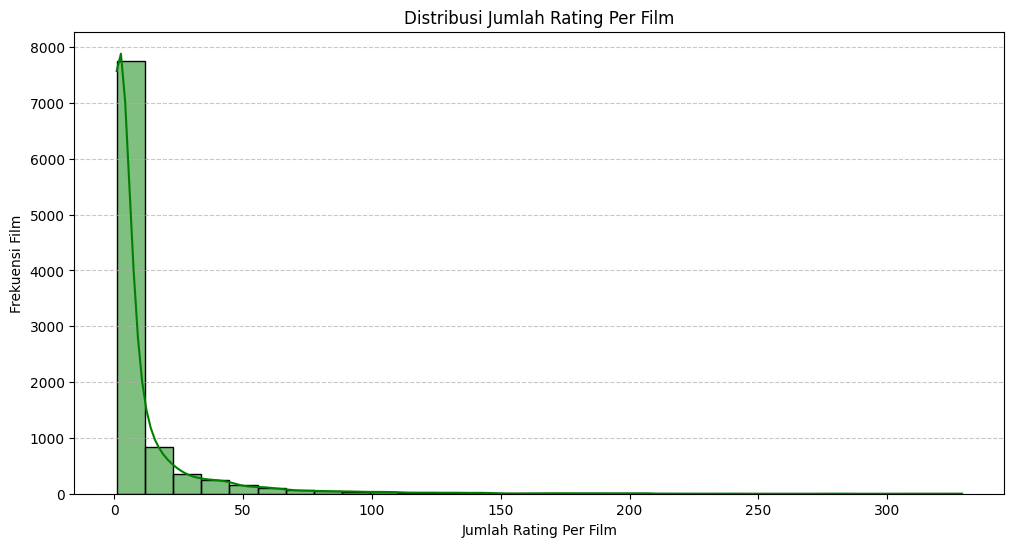

In [58]:
movie_ratings = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(12, 6))
sns.histplot(movie_ratings['count'], bins=30, kde=True, color='green')

plt.xlabel("Jumlah Rating Per Film")
plt.ylabel("Frekuensi Film")
plt.title("Distribusi Jumlah Rating Per Film")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Histogram distribusi jumlah rating per film menunjukkan bahwa mayoritas film dalam dataset hanya menerima sedikit rating dari pengguna, dengan sebagian besar berada di kisaran 0–10 rating. Pola ini mencerminkan adanya long-tail effect, di mana hanya sejumlah kecil film yang menarik perhatian luas dan mendapatkan banyak ulasan, sementara sebagian besar film kurang dikenal atau kurang diminati. Tren ini mengindikasikan bahwa persebaran rating tidak merata, dengan beberapa film yang berhasil membangun popularitas besar, kemungkinan karena faktor seperti pemasaran, kualitas produksi, atau keterlibatan komunitas.


# **Modelling**

## Content-Based Filtering

In [59]:
# Mengubah bentuk tf-idf vektor menjadi matriks
tfidf_matrix.todense()

matrix([[0.        , 0.4168036 , 0.51628768, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51229321, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.5784593 , 0.        , 0.81571125, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [60]:
# Konversi ke DataFrame dengan nama kolom sesuai fitur TF-IDF
df_tfidf = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=movies['title']
)

# Pastikan jumlah sampel tidak melebihi ukuran dataset
num_columns = min(20, df_tfidf.shape[1])  # Menyesuaikan jumlah kolom
num_rows = min(10, df_tfidf.shape[0])  # Menyesuaikan jumlah baris

# Sampling untuk menampilkan sebagian data
df_sampled = df_tfidf.sample(num_columns, axis=1).sample(num_rows, axis=0)

# Menampilkan hasil
df_sampled

,romance,fantasy,children,scifi,documentary,action,thriller,war,musical,crime,drama,western,imax,animation,comedy,adventure,mystery,horror,film-noir
title,,,,,,,,,,,,,,,,,,,
Harvard Man,0.533930,0.000000,0.0,0.000000,0.0,0.000000,0.501362,0.0,0.000000,0.588335,0.342661,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
"Brotherhood of the Wolf (Pacte des loups, Le)",0.000000,0.000000,0.0,0.000000,0.0,0.498109,0.491494,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.714368,0.000000,0.0
"Hello, Dolly!",0.505940,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.787642,0.000000,0.000000,0.0,0.0,0.0,0.351630,0.0,0.000000,0.000000,0.0
Practical Magic,0.454040,0.570036,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.291390,0.0,0.0,0.0,0.000000,0.0,0.619676,0.000000,0.0
District 9,0.000000,0.000000,0.0,0.578112,0.0,0.000000,0.462497,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.672222,0.000000,0.0
"Vow, The",0.841594,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.540111,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
Friends with Kids,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0
The Neon Demon,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.335738,0.0,0.0,0.0,0.000000,0.0,0.713988,0.614411,0.0
Under the Tuscan Sun,0.726452,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.466216,0.0,0.0,0.0,0.504886,0.0,0.000000,0.000000,0.0


In [61]:
# Hitung cosine similarity pada matrix
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.8136036 , 0.15259961, ..., 0.        , 0.42114166,
        0.26738778],
       [0.8136036 , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15259961, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57070525],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42114166, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26738778, 0.        , 0.57070525, ..., 0.        , 0.        ,
        1.        ]])

In [63]:
# Buat dataframe hasil dari cosine similarity
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies['title'], columns=movies['title'])
print('Shape:', cosine_sim_df.shape)

# Tampilkan similarity matrix
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9708, 9708)


title,Beyond Borders,Thesis (Tesis),"Union: The Business Behind Getting High, The",Hedgehog in the Fog,I Love You Again
title,,,,,
"Roaring Twenties, The",0.135412,0.499643,0.000000,0.0,0.274935
Attack of the Giant Leeches,0.000000,0.508115,0.000000,0.0,0.000000
The Fault in Our Stars,0.618639,0.212016,0.000000,0.0,0.366418
Man Up,0.427528,0.000000,0.245465,0.0,0.419287
Charly,0.160300,0.188320,0.000000,0.0,0.325466
"Pact, The",0.000000,0.681041,0.000000,0.0,0.000000
Titanica,0.000000,0.000000,0.564149,0.0,0.000000
"Bad News Bears, The",0.000000,0.000000,0.430109,0.0,0.734682
Sukiyaki Western Django,0.000000,0.000000,0.000000,0.0,0.000000


In [64]:
# Fungsi rekomendasi
def film_recommendations(title, similarity_data=cosine_sim_df, items=movies[['title', 'genres']], k=5):
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Ketik film yang ingin dicari
    closest = closest.drop(title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [65]:
# Tampilkan 5 data awal
movies.head()

,movieId,title,genres,year_of_release,genre_count
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,5
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,3
2,3,Grumpier Old Men,Comedy|Romance,1995.0,2
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,3
4,5,Father of the Bride Part II,Comedy,1995.0,1


In [66]:
# Cek movies
movies[movies.title.eq('Steal Big, Steal Little')]

,movieId,title,genres,year_of_release,genre_count
104,119,"Steal Big, Steal Little",Comedy,1995.0,1


In [67]:
# Mencari film rekomendasi mirip Steal Big, Steal Little
film_recommendations('Steal Big, Steal Little')

,title,genres
0,Andrew Dice Clay: Dice Rules,Comedy
1,Our Idiot Brother,Comedy
2,Half Baked,Comedy
3,"Change-Up, The",Comedy
4,Terri,Comedy


## Collaborative Filtering

In [68]:
# Membaca dataset
df = films
df

,userId,movieId,rating,timestamp,title,genres,year_of_release,genre_count
0,1,1,4.0,2000-07-30 18:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,5
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men,Comedy|Romance,1995.0,2
2,1,6,4.0,2000-07-30 18:37:04,Heat,Action|Crime|Thriller,1995.0,3
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en),Mystery|Thriller,1995.0,2
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The",Crime|Mystery|Thriller,1995.0,3
...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,Split,Drama|Horror|Thriller,2017.0,3
100832,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two,Action|Crime|Thriller,2017.0,3
100833,610,168250,5.0,2017-05-08 19:50:47,Get Out,Horror,2017.0,1
100834,610,168252,5.0,2017-05-03 21:19:12,Logan,Action|Scifi,2017.0,2


### Data Preparation

In [69]:
# Mendapatkan daftar unik userId dalam bentuk list
unique_user_ids = df['userId'].drop_duplicates().tolist()
print("Daftar userID unik:", unique_user_ids)

# Melakukan encoding userId menjadi indeks numerik
user_id_to_index = {user: idx for idx, user in enumerate(unique_user_ids)}
print("Mapping userID ke indeks:", user_id_to_index)

# Membalik encoding: dari indeks numerik ke userId asli
index_to_user_id = {idx: user for idx, user in enumerate(unique_user_ids)}
print("Mapping indeks ke userID:", index_to_user_id)

Daftar userID unik: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 21

In [70]:
# Mengambil daftar unik dari 'movieId' sebagai list
unique_movie_ids = df['movieId'].drop_duplicates().tolist()

# Melakukan encoding 'movieId' ke indeks numerik untuk pemrosesan lebih mudah
movie_to_index = {movie_id: index for index, movie_id in enumerate(unique_movie_ids)}

# Melakukan decoding indeks numerik kembali ke 'movieId' asli
index_to_movie = {index: movie_id for index, movie_id in enumerate(unique_movie_ids)}

In [82]:
# Menyesuaikan 'userId' dengan nilai yang telah dienkripsi dalam dataframe
df['user'] = df['userId'].map(user_id_to_index)

# Menyesuaikan 'movieId' dengan nilai yang telah dienkripsi dalam dataframe
df['films'] = df['movieId'].map(movie_to_index)

In [85]:
# Menentukan jumlah unik pengguna dalam dataset
num_users = len(user_id_to_index)
print(f"Jumlah Pengguna: {num_users}")

# Menentukan jumlah unik film dalam dataset
num_films = len(movie_to_index)
print(f"Jumlah Film: {num_films}")

# Mengonversi kolom rating ke tipe data float
df['rating'] = df['rating'].astype(np.float32)

# Menentukan nilai minimum dari rating dalam dataset
min_rating = df['rating'].min()

# Menentukan nilai maksimum dari rating dalam dataset
max_rating = df['rating'].max()
df['rating'] = df['rating'].apply(lambda r: (r - min_rating) / (max_rating - min_rating))

# Menampilkan hasil dalam format yang lebih terstruktur
print(f"Jumlah Pengguna: {num_users}, Jumlah Film: {num_films}, Rating Minimum: {min_rating}, Rating Maksimum: {max_rating}")

Jumlah Pengguna: 610
Jumlah Film: 9686
Jumlah Pengguna: 610, Jumlah Film: 9686, Rating Minimum: 0.0, Rating Maksimum: 1.0


### Split Data Training & Validation

In [86]:
# Sampling
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,title,genres,year_of_release,genre_count,user,films
30882,216,4025,0.333333,2001-02-14 16:59:25,Miss Congeniality,Comedy|Crime,2000.0,2,215,1804
83007,525,72226,0.888889,2016-10-14 20:58:32,Fantastic Mr. Fox,Adventure|Animation|Children|Comedy|Crime,2009.0,5,524,3514
88103,567,136020,0.111111,2018-05-02 19:29:04,Spectre,Action|Adventure|Crime,2015.0,3,566,968
74792,474,7311,0.666667,2004-02-02 13:52:30,"Goodbye, Mr. Chips",Drama|Romance,1939.0,2,473,5765
52750,346,1132,0.666667,2007-02-28 19:58:59,Manon of the Spring (Manon des sources),Drama,1986.0,1,345,3694
...,...,...,...,...,...,...,...,...,...,...
24888,176,457,1.000000,1996-08-15 11:33:13,"Fugitive, The",Thriller,1993.0,1,175,25
67547,437,852,1.000000,1997-03-30 11:25:03,Tin Cup,Comedy|Drama|Romance,1996.0,3,436,705
16867,105,134853,0.777778,2015-11-03 17:27:30,Inside Out,Adventure|Animation|Children|Comedy|Drama|Fantasy,2015.0,6,104,1085
77763,483,45517,0.444444,2008-07-12 14:16:09,Cars,Animation|Children|Comedy,2006.0,3,482,817


In [87]:
# Menyatukan informasi pengguna dan film sebagai pasangan nilai
input_data = df[['user', 'films']].values

# Normalisasi rating agar berada dalam rentang 0-1
normalized_ratings = df['rating'].values

# Membagi dataset menjadi data latih (80%) dan validasi (20%)
split_index = int(0.8 * df.shape[0])
x_train, x_val = input_data[:split_index], input_data[split_index:]
y_train, y_val = normalized_ratings[:split_index], normalized_ratings[split_index:]

# Menampilkan hasil pemrosesan
print(input_data, normalized_ratings)

[[ 215 1804]
 [ 524 3514]
 [ 566  968]
 ...
 [ 104 1085]
 [ 482  817]
 [ 599  673]] [0.33333334 0.8888889  0.11111111 ... 0.77777779 0.44444445 0.77777779]


### Proses Training

In [96]:
# Class recommendations
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_films, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)

        self.num_users = num_users
        self.num_films = num_films
        self.embedding_size = embedding_size

        # Embedding layer dengan regularisasi L2 untuk pengguna dan film
        self.user_embedding = tf.keras.layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-5)
        )
        self.user_bias = tf.keras.layers.Embedding(num_users, 1)

        self.film_embedding = tf.keras.layers.Embedding(
            input_dim=num_films,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-5)
        )
        self.film_bias = tf.keras.layers.Embedding(num_films, 1)

        # Menambahkan Dropout setelah embedding
        self.dropout = tf.keras.layers.Dropout(0.3)

    def call(self, inputs):
        # Mengambil embedding pengguna dan film
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        film_vector = self.film_embedding(inputs[:, 1])
        film_bias = self.film_bias(inputs[:, 1])

        # Operasi dot product antara pengguna dan film
        dot_product = tf.tensordot(user_vector, film_vector, axes=2)

        # Menjumlahkan hasil dot product dengan bias
        x = dot_product + user_bias + film_bias

        # Mengaplikasikan Dropout sebelum aktivasi
        x = self.dropout(x)

        # Aktivasi dengan fungsi sigmoid
        return tf.nn.sigmoid(x)

In [103]:
# Inisialisasi model
model = RecommenderNet(num_users, num_films, embedding_size=50)

# Compile model dengan BinaryCrossentropy, Adam optimizer, dan RMSE sebagai metrik evaluasi
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Callback early stopping untuk menghentikan training jika validation RMSE stagnan
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [106]:
# Training model
history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/25
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.5978 - root_mean_squared_error: 0.1915 - val_loss: 0.6012 - val_root_mean_squared_error: 0.1924
Epoch 2/25
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.5955 - root_mean_squared_error: 0.1878 - val_loss: 0.6009 - val_root_mean_squared_error: 0.1920
Epoch 3/25
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.5945 - root_mean_squared_error: 0.1869 - val_loss: 0.6008 - val_root_mean_squared_error: 0.1919
Epoch 4/25
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.5929 - root_mean_squared_error: 0.1858 - val_loss: 0.6007 - val_root_mean_squared_error: 0.1918
Epoch 5/25
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.5926 - root_mean_squared_error: 0.1854 - val_loss: 0.6007 - val_root_mean_squared_error: 0.1917
Epoch 6/25
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.5929 - root_mean_squared_error: 0.1861 - val_loss: 0.6006 - val_root_mean_squared_error: 0.1916
Epoch 7/25
5039/5039 ━━━━━━━━━━━━━

### Evaluasi Model

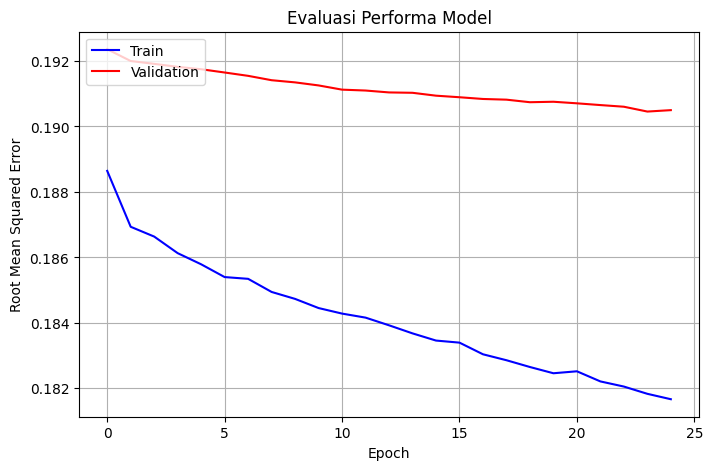

In [107]:
# Memvisualisasikan evaluasi metrik model
plt.figure(figsize=(8, 5))
plt.plot(history.history['root_mean_squared_error'], label="Train", color='blue')
plt.plot(history.history['val_root_mean_squared_error'], label="Validation", color='red')

# Menambahkan elemen grafik untuk memperjelas visualisasi
plt.title("Evaluasi Performa Model")
plt.xlabel("Epoch")
plt.ylabel("Root Mean Squared Error")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Mendapatkan Rekomendasi

In [108]:
# Films
films_df = movies.copy()
films_df.head()

,movieId,title,genres,year_of_release,genre_count
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,5
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,3
2,3,Grumpier Old Men,Comedy|Romance,1995.0,2
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,3
4,5,Father of the Bride Part II,Comedy,1995.0,1


In [109]:
# Data ratings
df = films.copy()
df.head()

,userId,movieId,rating,timestamp,title,genres,year_of_release,genre_count,user,films
0,1,1,0.777778,2000-07-30 18:45:03,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,5,0,2.0
1,1,3,0.777778,2000-07-30 18:20:47,Grumpier Old Men,Comedy|Romance,1995.0,2,0,4.0
2,1,6,0.777778,2000-07-30 18:37:04,Heat,Action|Crime|Thriller,1995.0,3,0,7.0
3,1,47,1.000000,2000-07-30 19:03:35,Seven (a.k.a. Se7en),Mystery|Thriller,1995.0,2,0,48.0
4,1,50,1.000000,2000-07-30 18:48:51,"Usual Suspects, The",Crime|Mystery|Thriller,1995.0,3,0,51.0


In [110]:
# Mengambil sampel user
user_id = df.userId.sample(1).iloc[0]
films_visited_by_user = df[df.userId == user_id]

# bitwise operators (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
films_not_visited = films_df[~films_df['movieId'].isin(films_visited_by_user.movieId.values)]['movieId']
films_not_visited = list(
    set(films_not_visited)
    .intersection(set(index_to_user_id.keys()))
)

films_not_visited = [[index_to_user_id.get(x)] for x in films_not_visited]
user_encoder = user_id_to_index.get(user_id)
user_films_array = np.hstack(
    ([[user_encoder]] * len(films_not_visited), films_not_visited)
)

In [111]:
# Mendapatkan rekomendasi
ratings = model.predict(user_films_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_films_ids = [
    index_to_movie.get(films_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Films with high ratings from user')
print('----' * 8)

top_films_user = (
    films_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

films_df_rows = films_df[films_df['movieId'].isin(top_films_user)]
for row in films_df_rows.itertuples():
    print(row.title, ':', row.genres)

print('----' * 8)
print('Top 10 films recommendation')
print('----' * 8)

recommended_films = films_df[films_df['movieId'].isin(recommended_films_ids)]
for row in recommended_films.itertuples():
    print(row.title, ':', row.genres)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Showing recommendations for users: 408
Films with high ratings from user
--------------------------------
Ghost in the Shell (Kôkaku kidôtai) : Animation|Scifi
Lord of the Rings: The Fellowship of the Ring, The : Adventure|Fantasy
Lord of the Rings: The Two Towers, The : Adventure|Fantasy
Illusionist, The : Drama|Fantasy|Mystery|Romance
Prestige, The : Drama|Mystery|Scifi|Thriller
--------------------------------
Top 10 films recommendation
--------------------------------
Usual Suspects, The : Crime|Mystery|Thriller
Star Wars: Episode IV - A New Hope : Action|Adventure|Scifi
Pulp Fiction : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The : Crime|Drama
Schindler's List : Drama|War
Reservoir Dogs : Crime|Mystery|Thriller
Princess Bride, The : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) : Action|Adventure
Apocalypse Now : Action|Drama|War
Fight Club : Action|Crime|Drama|Thrill